In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import itertools
import scipy.misc
import os
import matplotlib.pyplot as plt
%matplotlib inline

# 그리드 세계 구현

In [2]:
class gameOb():
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

class gameEnv():
    def __init__(self, partial, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        self.partial = partial
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(), 1, 1, 2, None, 'hero')
        self.objects.append(hero)
        bug = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug)
        hole = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole)
        bug2 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug2)
        hole2 = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole2)
        bug3 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug3)
        bug4 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(bug4)
        state = self.renderEnv()
        self.state = state
        return state
    
    def moveChar(self, direction):
        # 0-up, 1-down, 2-left, 3-right
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        penalize = 0.
        
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY - 2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX - 2:
            hero.x += 1
        if hero.x == heroX and hero.y == heroY:
            penalize = 0.0
        self.objects[0] = hero
        return penalize
    
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
        
        for pos in currentPositions:
            points.remove(pos)
        
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]
    
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        ended = False
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 1, 1, 'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 0, -1, 'fire'))
                return other.reward, False
        if ended == False:
            return 0.0, False
    
    def renderEnv(self):
        # a = np.zeros([self.sizeY, self.sizeX, 3])
        a = np.ones([self.sizeY + 2, self.sizeX + 2, 3])
        a[1:-1, 1:-1, :] = 0
        hero = None
        for item in self.objects:
            a[item.y + 1 : item.y + item.size + 1, item.x + 1 : item.x + item.size + 1, item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
        if self.partial == True:
            a = a[hero.y:hero.y3, hero.x:hero.x+3, :]
        b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
        c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
        d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')
        a = np.stack([b, c, d], axis=2)
        return a
    def step(self, action):
        penalty = self.moveChar(action)
        reward, done = self.checkGoal()
        state = self.renderEnv()
        if reward == None:
            print(done)
            print(reward)
            print(penalty)
            return state, (reward+penalty), done
        else:
            return state, (reward+penalty), done
            


# 게임 환경 로딩

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


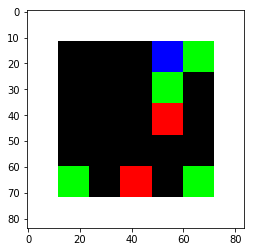

In [3]:
env = gameEnv(partial=False, size=5)

# 네트워크 만들기

In [4]:
class Qnetwork():
    def __init__(self, h_size):
        # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다.(flattening)
        # 그 다음 배열의 크기를 재조절하고 4개의 합성곱 계층을 거쳐 처리한다.
        self.scalarInput = tf.placeholder(shape=[None,21168], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1, 84, 84, 3])
        self.conv1 = slim.conv2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8, 8], stride=[4,4], padding="VALID", biases_initializer=None)
        self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4], stride=[2,2], padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3], stride=[1,1], padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7], stride=[1,1], padding='VALID', biases_initializer=None)
        
        # 마지막 합성곱 계층에서 출력값을 취한 후
        # 이를 어드밴티지 스트림과 가치 스트림으로 분리한다.
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size // 2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size // 2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        # 최종 Q값을 얻기 위해 어드밴티지 스트림과 가치 스트림을 조합한다.
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        # 타깃 Q값과 예측 Q값의 차의 제곱합을 구함으로써 비용을 얻는다.
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        

# 경험 리플레이

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)
    
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

# 게임의 프레임의 크기를 재조절해주는 함수
def processState(states):
    return np.reshape(states, [21168])

# 1차 네트워크의 매개변수에 맞춰 타깃 네트워크의 매개변수를 업데이트
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx, var in enumerate(tfVars[0:total_vars // 2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value() * tau) + ((1 - tau) * tfVars[idx + total_vars//2].value())))
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

# 네트워크 학습

학습 매개변수를 설정

In [6]:
batch_size = 32 # 각 학습 단계에서 사용할 경험 배치의 수
update_freq = 4 # 학습 단계 업데이트 빈도
y = .99 # 타깃 Q값에 대한 할인 계수
startE = 1 # 랜덤한 액션을 시작할 가능성
endE = 0.1 # 랜던한 액션을 끝낼 가능성
anneling_steps = 10000 # startE에서 endE로 줄어드는 데 필요한 학습 단계 수
num_episodes = 10000 # 네트워크를 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000 # 학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 # 허용되는 최대 에피소드 길이
load_model = False # 저장된 모델을 로드할 지 여부
path = './dqn' # 모델을 저장할 경로
h_size = 512 # 어드밴티디 / 가치 스트림으로 분리되기 전 마지막 합성곱 계층의 크기
tau = 0.001 # 타깃 네트워크를 제 1 네트워크로 업데이트 하는 비율

학습 과정 구현


In [ ]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)
myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율을 설정
e = startE
stepDrop = (startE - endE) / anneling_steps

# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성
jList = []
rList = []
total_steps = 0

# 모델을 저장할 경로를 생성
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    # 타깃 네트우크가 제 1네트워크와 동일하도록 설정
    updateTarget(targetOps, sess)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        # 환경을 리셋하고 첫번째 새로운 관찰을 얻는다.
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        # Q 네트워크
        # 에이전트가 블록에 도달하기까지 최대 50회 시도하고 종료
        while j < max_epLength:
            j += 1
            # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0, 4)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]
            s1, r, d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            # 에피소드 버퍼에 경험을 저장
            episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    # 경험에서 랜덤하게 배치 하나를 샘플링
                    trainBatch = myBuffer.sample(batch_size)
                    # 타깃 Q값에 대해 더블 DQN 업데이트를 수행
                    Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size), Q1]
                    targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)
                    # 타깃 값을 이용해 네트워크를 업데이트
                    _ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    # 타깃 네트워크가 제1네트워크와 동일하도록 설정
                    updateTarget(targetOps, sess)
            rAll += r
            s = s1
        
            if d == True:
                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        
        # 정기적으로 모델 저장
        if i % 1000 == 0:
            saver.save(sess, path+'/model-'+str(i)+'.cptk')
            print('Saved Model')
        if len(rList) % 10 == 0:
            print(total_steps, np.mean(rList[-10:]), e)
    saver.save(sess, path+'/model-'+str(i)+'.cptk')
print("Percent of successful episodes: " + str(sum(rList) / num_episodes))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Saved Model
500 2.1 1
1000 2.2 1
1500 1.3 1
2000 3.1 1
2500 2.4 1
3000 1.4 1
3500 3.0 1
4000 1.4 1
4500 1.6 1
5000 2.5 1
5500 2.2 1
6000 2.8 1
6500 1.2 1
7000 2.7 1
7500 1.3 1
8000 2.5 1
8500 1.6 1
9000 2.8 1
9500 2.5 1
10000 1.8 1
10500 1.2 0.9549999999999828
11000 2.4 0.9099999999999655
11500 1.3 0.8649999999999483
12000 1.3 0.819999999999931
12500 2.6 0.7749999999999138
13000 3.0 0.7299999999998965
13500 3.0 0.6849999999998793
14000 2.2 0.639999999999862
14500 2.1 0.5949999999998448


# 학습 과정 시각화

In [ ]:
rMat = np.resize(np.array(rList), [len(rList)//100, 100])
rMean = np.avarage(rMat, 1)
plt.plot(rMean)